# Fusion de données

In [ ]:
#@title Chargement des données
import pandas as pd
import os

# Liste des années pour les fichiers
years = range(2021, 2025)

# Créer une liste pour stocker les DataFrames
dataframes = []

# Parcourir les fichiers et charger 20% de chaque fichier
for year in years:
    file_name = f"AMOS_EXE_PRS_extraction_IMT_{year}_clean.csv"
    if os.path.exists(file_name):
        # Charger le fichier CSV
        df = pd.read_csv(file_name)
        # Prendre un échantillon de 20%
        df_sample = df.sample(frac=0.2, random_state=42)
        dataframes.append(df_sample)
    else:
        print(f"Fichier introuvable : {file_name}")

# Fusionner les DataFrames
merged_df = pd.concat(dataframes, ignore_index=True)

# Sauvegarder le DataFrame fusionné (facultatif)
merged_df.to_csv("merged_sampled_data.csv", index=False)

In [ ]:
#@title Lecture des données
import pandas as pd
import numpy as np
merged_df = pd.read_csv("merged_sampled_data.csv")

In [ ]:
#@title Taille de la base de données
len(merged_df)

559908

In [ ]:
#@title Quelques variables rajoutés (en se basant sur les indicateurs de fraudes)
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Calcul du Délai prescription-facturation (en mois)
merged_df['Délai prescription-facturation'] = (
    (merged_df['Année de remboursement'] - merged_df['Année de prescription']) * 12 +
    (merged_df['Mois de remboursement'] - merged_df['Mois de prescription'])
)

# Correction : Inverser les délais longs pour favoriser la détection des délais courts comme anomalies
merged_df['Délai inversé'] = 1 / (merged_df['Délai prescription-facturation'] + 1)

# Calcul des remboursements par mois
remboursements_par_mois = merged_df.groupby(
    ['N° PS exécutant Statistique', 'Année de remboursement', 'Mois de remboursement']
)['Nombre de bénéficiaires'].sum().reset_index(name='Remboursements par mois')
merged_df = merged_df.merge(remboursements_par_mois, on=['N° PS exécutant Statistique', 'Année de remboursement', 'Mois de remboursement'])

# Calcul de la proportion de jeunes pour chaque 'N° PS exécutant Statistique'
proportion_jeunes = merged_df.groupby('N° PS exécutant Statistique')['Age du bénéficiaire'].apply(lambda x: (x < 18).mean())
merged_df = merged_df.merge(proportion_jeunes.rename('Proportion jeunes'), on='N° PS exécutant Statistique')

# Ajouter une colonne binaire 'Age supérieur à 18'
merged_df['Age supérieur à 18'] = (merged_df['Age du bénéficiaire'] > 18).astype(int)

saisonnalité = merged_df.groupby('N° PS exécutant Statistique')['Remboursements par mois'].std()
# Seuil basé sur le 5ème percentile
seuil_saisonnalité = np.percentile(saisonnalité, 5)

merged_df = merged_df.merge(saisonnalité.rename('Écart-type remboursements'), on='N° PS exécutant Statistique')
merged_df['Fraude saisonnalité'] = merged_df['Écart-type remboursements'] < seuil_saisonnalité

In [ ]:
#@title Modele de détéction d'**anomalies**

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Sélection des colonnes pertinentes
features = [
    'Délai inversé',
    'Remboursements par mois',
    'Quantité d\'acte - Prestation seule (pas presta. de réf.)',
    'Montant de la dépense - Prestation seule',
    'Proportion jeunes',
    'Age supérieur à 18',
    'Écart-type remboursements'
]

# Remplir les valeurs manquantes avec la moyenne de chaque colonne (si nécessaire)
merged_df[features] = merged_df[features].fillna(merged_df[features].mean())

# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(merged_df[features])

# Application de l'Isolation Forest
model = IsolationForest(contamination=0.01, random_state=42)
merged_df['Fraude_anomalie'] = model.fit_predict(X_scaled)


In [ ]:
#@title Vue générale des résultats
# Les anomalies seront marquées par -1, et les données normales par 1
merged_df['Fraude_anomalie'] = merged_df['Fraude_anomalie'].map({1: 0, -1: 1})  # 0 pour normal, 1 pour fraude

# Affichage du nombre d'anomalies détectées
print(f"Nombre d'anomalies détectées : {merged_df['Fraude_anomalie'].sum()}")

Nombre d'anomalies détectées : 5594


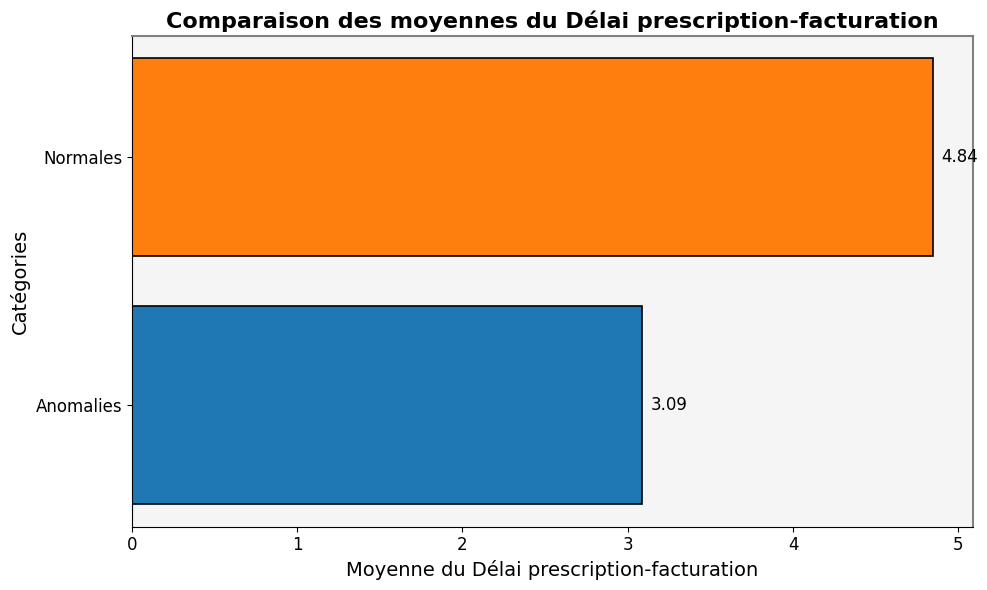

In [ ]:
#@title Délai prescription-facturation (généralement courtes pour les fraudes!)
import matplotlib.pyplot as plt
import pandas as pd

# Comparaison des moyennes des variables pour les anomalies et les normales
anomalies = merged_df[merged_df['Fraude_anomalie'] == 1]
normales = merged_df[merged_df['Fraude_anomalie'] == 0]

# Calcul des moyennes
mean_anomalies = anomalies['Délai prescription-facturation'].mean()
mean_normales = normales['Délai prescription-facturation'].mean()

# Préparer les données pour le graphique
categories = ['Anomalies', 'Normales']
means = [mean_anomalies, mean_normales]

# Création du graphique barh
plt.figure(figsize=(10, 6))

# Choisir un jeu de couleurs stylé
colors = ['#1f77b4', '#ff7f0e']

# Tracer le graphique en barh
bars = plt.barh(categories, means, color=colors, edgecolor='black', linewidth=1.2)

# Ajouter des labels sur les barres
for bar in bars:
    plt.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.2f}', va='center', ha='left', fontsize=12, color='black')

# Ajouter des titres et des labels
plt.xlabel("Moyenne du Délai prescription-facturation", fontsize=14)
plt.ylabel("Catégories", fontsize=14)
plt.title("Comparaison des moyennes du Délai prescription-facturation", fontsize=16, fontweight='bold')

# Personnaliser les axes et l'apparence
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Ajouter un fond et des bordures stylisées
plt.gca().set_facecolor('whitesmoke')
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['top'].set_color('gray')
plt.gca().spines['right'].set_linewidth(1.5)
plt.gca().spines['right'].set_color('gray')

# Afficher le graphique
plt.tight_layout()
plt.show()


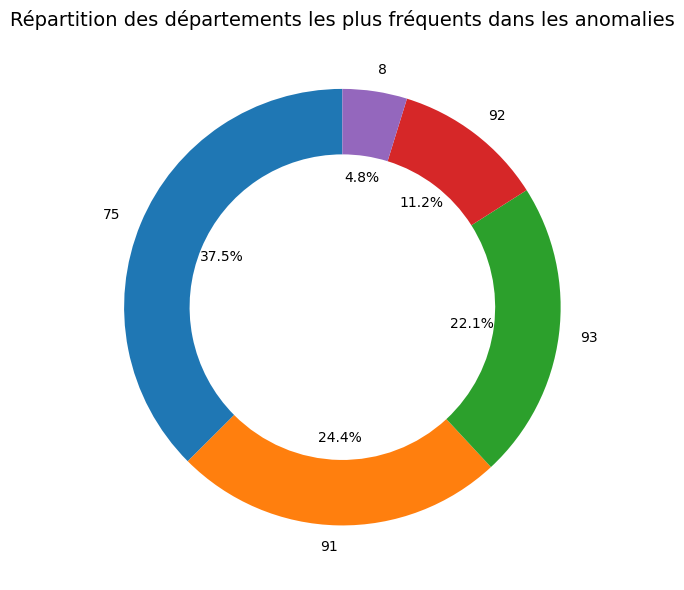

In [ ]:
#@title Départements fréquents dans les anomalies détectées

import matplotlib.pyplot as plt

# Comptage des départements les plus fréquents dans anomalies
top_departments = anomalies['Département d\'exercice du PS exécutant'].value_counts().head(5)

# Création du donut chart
plt.figure(figsize=(8, 6))
plt.pie(top_departments, labels=top_departments.index, autopct='%1.1f%%', startangle=90, wedgeprops={'width': 0.3})

# Ajouter un cercle au centre pour créer l'effet donut
centre_circle = plt.Circle((0, 0), 0.50, color='white', fc='white', lw=0)
plt.gca().add_artist(centre_circle)

# Ajouter un titre
plt.title("Répartition des départements les plus fréquents dans les anomalies", fontsize=14)

# Afficher le graphique
plt.tight_layout()
plt.show()


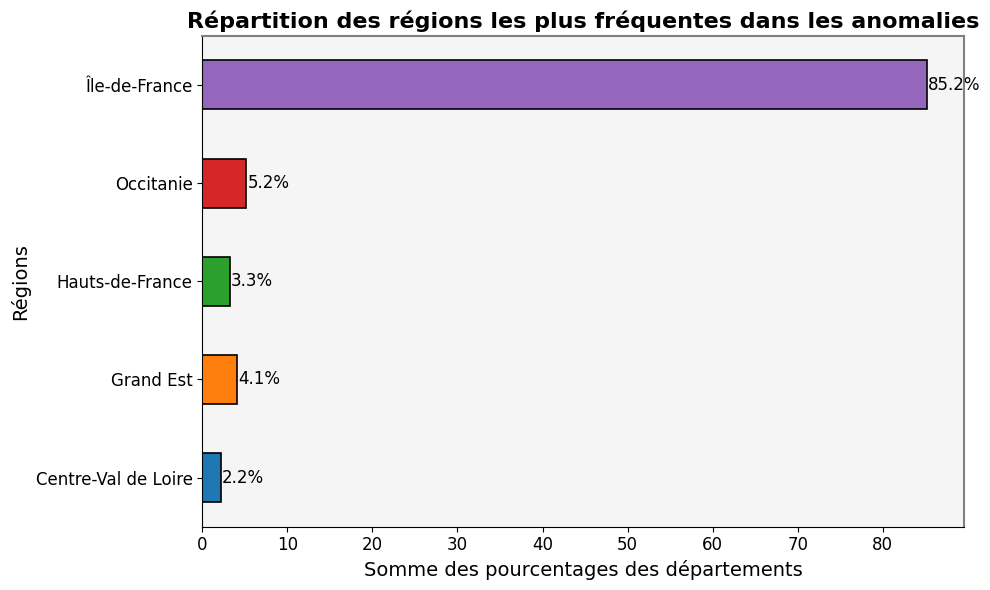

In [ ]:
#@title Régions fréquentes dans les anomalies détectées

# Comptage des départements les plus fréquents dans anomalies
top_departments = anomalies['Département d\'exercice du PS exécutant'].value_counts().head(10)

# Mappage des départements vers les régions
top_departments_regions = top_departments.index.map(departement_to_region)

# Comptage des régions les plus fréquentes dans anomalies (après mappage)
region_counts = top_departments_regions.value_counts()

# Mappage des départements aux régions
department_to_region = top_departments.index.to_series().map(departement_to_region)

# Calcul de la somme des pourcentages des départements dans chaque région
region_percentage = top_departments.groupby(top_departments_regions).sum() / top_departments.sum() * 100

# Création du barh chart pour les régions
plt.figure(figsize=(10, 6))

# Choisir un jeu de couleurs stylé
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Tracer le graphique en barh
bars = region_percentage.plot(kind='barh', color=colors, edgecolor='black', linewidth=1.2)

# Ajouter des labels sur les barres
for index, value in enumerate(region_percentage):
    # Ajouter l'étiquette dans la barre, avec la somme des pourcentages des départements
    plt.text(value + 0.1, index, f'{value:.1f}%', va='center', ha='left', fontsize=12, color='black')

# Ajouter des titres et des labels
plt.xlabel("Somme des pourcentages des départements", fontsize=14)
plt.ylabel("Régions", fontsize=14)
plt.title("Répartition des régions les plus fréquentes dans les anomalies", fontsize=16, fontweight='bold')

# Personnaliser les axes et l'apparence
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Ajouter un fond et des bordures stylisées
plt.gca().set_facecolor('whitesmoke')
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['top'].set_color('gray')
plt.gca().spines['right'].set_linewidth(1.5)
plt.gca().spines['right'].set_color('gray')

# Afficher le graphique
plt.tight_layout()
plt.show()


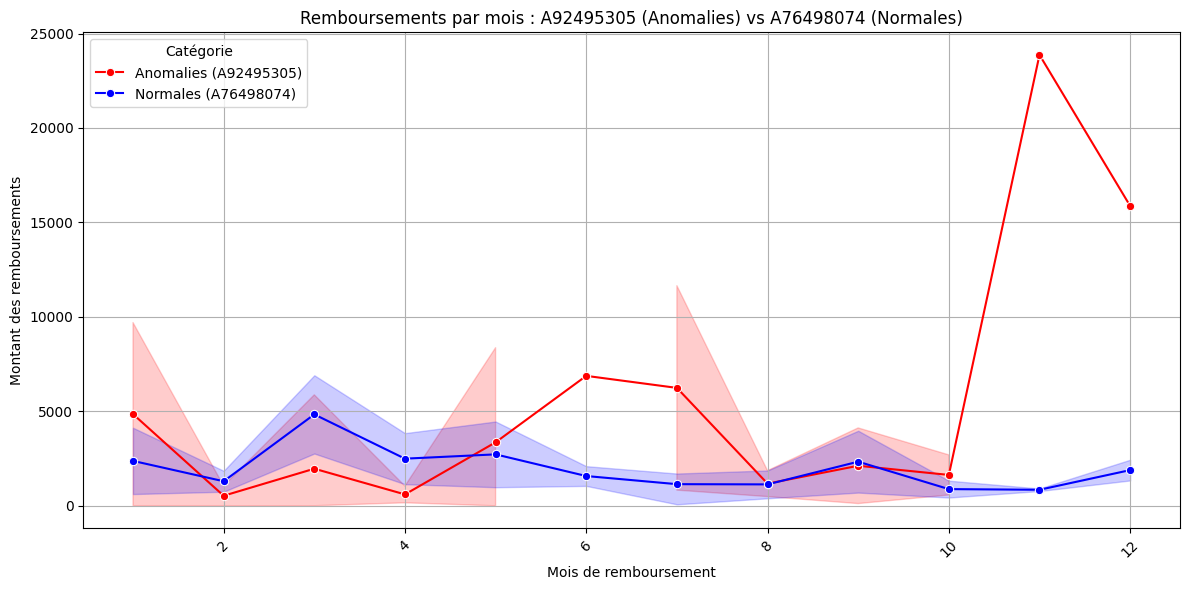

Établissement le plus fréquent dans les anomalies : A92495305
Établissement le plus fréquent dans les normales : A76498074


In [ ]:
#@title Exemple de détéction (à vérifier)

import seaborn as sns
import matplotlib.pyplot as plt

# Sélectionner l'établissement le plus fréquent dans les anomalies et les normales
etablissement_anomalie_id = anomalies['N° PS exécutant Statistique'].value_counts().idxmax()  # L'établissement le plus fréquent dans les anomalies
etablissement_normal_id = normales['N° PS exécutant Statistique'].value_counts().idxmax()  # L'établissement le plus fréquent dans les normales

# Filtrer les données pour ces deux établissements
anomalies_etablissement = anomalies[anomalies['N° PS exécutant Statistique'] == etablissement_anomalie_id]
normales_etablissement = normales[normales['N° PS exécutant Statistique'] == etablissement_normal_id]

# Calculer les remboursements totaux par mois pour anomalies et normales
anomalies_mois = anomalies_etablissement.groupby(['Année de remboursement', 'Mois de remboursement'])['Remboursements par mois'].sum().reset_index()
normales_mois = normales_etablissement.groupby(['Année de remboursement', 'Mois de remboursement'])['Remboursements par mois'].sum().reset_index()

# Créer un graphique
plt.figure(figsize=(12, 6))

# Tracer les remboursements pour l'établissement avec anomalies
sns.lineplot(data=anomalies_mois, x='Mois de remboursement', y='Remboursements par mois', label=f'Anomalies ({etablissement_anomalie_id})', color='red', marker='o')

# Tracer les remboursements pour l'établissement normal
sns.lineplot(data=normales_mois, x='Mois de remboursement', y='Remboursements par mois', label=f'Normales ({etablissement_normal_id})', color='blue', marker='o')

# Ajouter des détails au graphique
plt.title(f'Remboursements par mois : {etablissement_anomalie_id} (Anomalies) vs {etablissement_normal_id} (Normales)')
plt.xlabel('Mois de remboursement')
plt.ylabel('Montant des remboursements')
plt.legend(title='Catégorie', loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)

# Afficher le graphique
plt.tight_layout()
plt.show()

# Affichage des établissements sélectionnés pour confirmation
print(f"Établissement le plus fréquent dans les anomalies : {etablissement_anomalie_id}")
print(f"Établissement le plus fréquent dans les normales : {etablissement_normal_id}")



[("Quantité d'acte - Prestation seule (pas presta. de réf.) <= 0.20", 0.20165865458708238), ('Proportion jeunes <= -0.34', 0.09974963751396845), ('-0.27 < Écart-type remboursements <= -0.16', 0.06607229303887123), ('Remboursements par mois <= -0.35', 0.05593308344418537), ('Montant de la dépense - Prestation seule <= -0.47', -0.045211482536925605), ('Délai inversé <= -0.68', 0.0025519639160552833), ('Age supérieur à 18 <= 0.10', 0.0)]


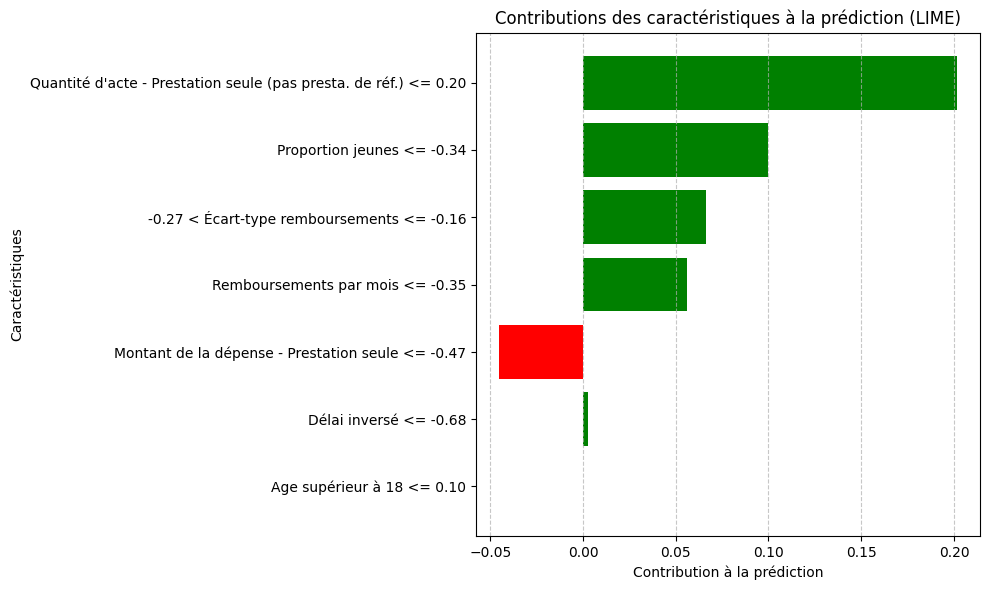

In [ ]:
#@title Exploration des méthodes d'IA explicatives (à discuter aussi)

from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import numpy as np

# Création de l'explainer LIME
explainer = LimeTabularExplainer(
    training_data=X_scaled,  # Données standardisées
    mode="classification",  # Mode classification pour Isolation Forest
    feature_names=features,  # Utilisation des features du modèle
    discretize_continuous=True  # Rendre les explications plus lisibles
)

# Sélection d'une observation pour l'explication (index de la ligne à expliquer)
observation_index = 0  # Par exemple, la première ligne
observation = X_scaled[observation_index].reshape(1, -1)

# Fonction de prédiction pour LIME, qui fonctionne sur les données normalisées
def predict_proba(X):
    scores = model.decision_function(X)  # Obtenir les scores de décision
    probas = (scores - scores.min()) / (scores.max() - scores.min())  # Normalisation des scores
    return np.vstack([1 - probas, probas]).T

# Générer l'explication locale
exp = explainer.explain_instance(
    data_row=observation.flatten(),
    predict_fn=predict_proba
)

# Afficher les explications sous forme textuelle
print(exp.as_list())

# Créer un barplot avec les contributions des caractéristiques
feature_contributions = exp.as_list()

# Séparer les noms des caractéristiques et leurs contributions
features, contributions = zip(*feature_contributions)

# Créer un barplot horizontal
plt.figure(figsize=(10, 6))
colors = ['green' if value > 0 else 'red' for value in contributions]  # Vert pour contributions positives, rouge pour négatives
plt.barh(features, contributions, color=colors)

# Ajouter des labels et un titre
plt.xlabel("Contribution à la prédiction")
plt.ylabel("Caractéristiques")
plt.title("Contributions des caractéristiques à la prédiction (LIME)")
plt.gca().invert_yaxis()  # Inverser l'axe Y pour une meilleure lisibilité
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Afficher le graphe
plt.tight_layout()
plt.show()
